# **Semantic Segmentation on the FloodNet Dataset**

> _Natural disasters are becoming more frequent and severe, threatening human health and infrastructure. Accurate and timely information is crucial for effective disaster management. Small unmanned aerial systems (UAS) with affordable sensors can quickly collect thousands of images, even in difficult-to-reach areas, which helps in rapid response and recovery. However, analyzing these large datasets to extract useful information remains a significant challenge._

The **FloodNet Dataset** provides high-resolution UAS imagery with detailed semantic annotations of damages collected after **Hurricane Harvey**. The whole dataset has 2343 images, divided into training (60%), validation (20%), and test (20%) sets. The semantic segmentation labels include: Background, Building Flooded, Building Non-Flooded, Road Flooded, Road Non-Flooded, Water, Tree, Vehicle, Pool and Grass. The **goal** is to create and train a strong model for semantic segmentation. This model will be used in a dashboard to detect flood damages in real-time.

**_References:_**
- [FloodNet Dataset Repository](https://github.com/BinaLab/FloodNet-Supervised_v1.0)
- [FloodNet Paper](https://ieeexplore.ieee.org/document/9460988)

**_Dashboard:_**
- [Dashboard Repository](https://github.com/ywdavi/FloodDetection/tree/main)
- [Streamlit App](https://flooddetection.streamlit.app/)

### Libraries

In [1]:
!pip install torchsummary
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 997.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
from collections import Counter

import glob
import os
import shutil

import cv2
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

### Data Loading

This script detects whether you are running in a `Colab` enviroment or a `Kaggle` enviroment. In `Colab` it automatically downloads the dataset while in `Kaggle` you need to ensure the dataset is already available in the inputs.



In [3]:
# This detects if we are in a Colab framework or a Kaggle one


if os.path.exists("/content/") and os.path.isdir("/content/"):
      print("Colab framework")
      !wget -O /content/FloodNet.zip https://www.dropbox.com/scl/fo/k33qdif15ns2qv2jdxvhx/ANGaa8iPRhvlrvcKXjnmNRc?rlkey=ao2493wzl1cltonowjdbrnp7f&e=3&st=evmnheic&dl=0

      with zipfile.ZipFile("/content/FloodNet.zip", 'r') as zip_ref:
        zip_ref.extractall("/content/FloodNet")

      shutil.rmtree("/content/FloodNet/FloodNet-Supervised_v1.0/test/test-label-img")
      shutil.rmtree("/content/FloodNet/FloodNet-Supervised_v1.0/train/train-label-img")
      shutil.rmtree("/content/FloodNet/FloodNet-Supervised_v1.0/val/val-label-img")

      path = "/content/FloodNet/"

else:
      print("Kaggle framework")
      path = "/kaggle/input/floodnet-zip/"

Colab framework
--2024-07-11 09:50:21--  https://www.dropbox.com/scl/fo/k33qdif15ns2qv2jdxvhx/ANGaa8iPRhvlrvcKXjnmNRc?rlkey=ao2493wzl1cltonowjdbrnp7f
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucff28c2cc6b5934760b1ace8dbc.dl.dropboxusercontent.com/zip_download_get/B54evX2FMT1OQw3KcW4nNh0Duu9falE84dU77oQdHd6gJfuy9kOcm1BZO9Br_2tqW50nzSpfGfADdOFWJTNJHNV7FJrlv2TlHudOxamfcRj1jw# [following]
--2024-07-11 09:50:26--  https://ucff28c2cc6b5934760b1ace8dbc.dl.dropboxusercontent.com/zip_download_get/B54evX2FMT1OQw3KcW4nNh0Duu9falE84dU77oQdHd6gJfuy9kOcm1BZO9Br_2tqW50nzSpfGfADdOFWJTNJHNV7FJrlv2TlHudOxamfcRj1jw
Resolving ucff28c2cc6b5934760b1ace8dbc.dl.dropboxusercontent.com (ucff28c2cc6b5934760b1ace8dbc.dl.dropboxusercontent.com)... 162.125.6.15, 2620:100:6019:15::a27d:40f
Connecting to ucff28c2cc6b5934760b1a

Now we can find all the paths and define the color palette.

In [4]:
# Masks

train_path_m = path + "ColorMasks-FloodNetv1.0/ColorMasks-TrainSet/*.png"
val_path_m = path + "ColorMasks-FloodNetv1.0/ColorMasks-ValSet/*.png"
test_path_m = path + "ColorMasks-FloodNetv1.0/ColorMasks-TestSet/*.png"
train_pathS_m = sorted(glob.glob(train_path_m))
val_pathS_m = sorted(glob.glob(val_path_m))
test_pathS_m = sorted(glob.glob(test_path_m))

# Images

train_path = path + "FloodNet-Supervised_v1.0/train/train-org-img/*.jpg"
val_path = path + "FloodNet-Supervised_v1.0/val/val-org-img/*.jpg"
test_path = path + "FloodNet-Supervised_v1.0/test/test-org-img/*.jpg"
train_pathS = sorted(glob.glob(train_path))
val_pathS = sorted(glob.glob(val_path))
test_pathS = sorted(glob.glob(test_path))

# Define classes and palette

classes = ['background', 'building-flooded','building-non-flooded', 'road-flooded', 'road-non-flooded', 'water', 'tree', 'vehicle','pool', 'grass']
RGBs = [[0.0, 0.0, 0.0],[255.0, 0.0, 0.0], [180.0, 120.0, 120.0], [160.0, 150.0, 20.0], [140.0, 140.0, 140.0],
        [61.0, 230.0, 250.0], [0.0, 82.0, 255.0],[255.0, 0.0, 245.0], [255.0, 235.0, 0.0], [4.0, 250.0, 7.0]]
normalized_palette = np.round(np.array(RGBs, dtype=np.float32) / 255 , 5)
normalized_palette_tuples = [tuple(color) for color in normalized_palette.tolist()]
classes_palette = dict(zip(normalized_palette_tuples, classes))
classes_to_index = {cls: idx for idx, cls in enumerate(classes)}

print("Train set size:", len(train_pathS))
print("Validation set size:", len(val_pathS))
print("Test set size:", len(test_pathS))

Train set size: 1445
Validation set size: 450
Test set size: 448


### Visualizations

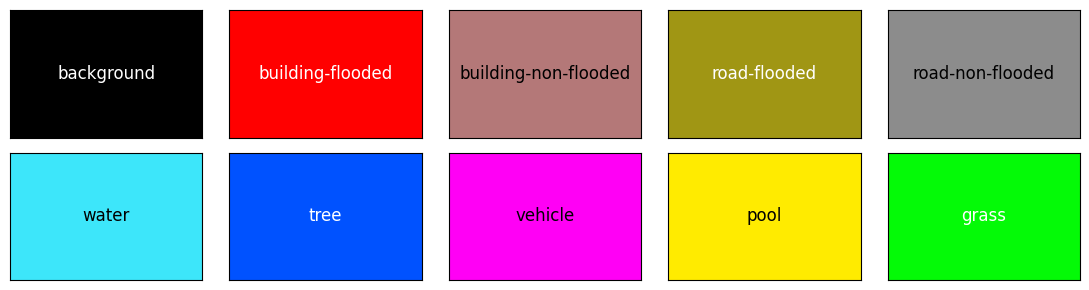

In [41]:
# Palette and classes

fig, axes = plt.subplots(2, 5, figsize=(11, 3))

axes = axes.flatten()
for ax, cls, rgb in zip(axes, classes, normalized_palette):
    ax.set_facecolor(rgb)
    ax.text(0.5, 0.5, cls, ha='center', va='center', fontsize=12, color='white' if sum(rgb) < 1.5 else 'black')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

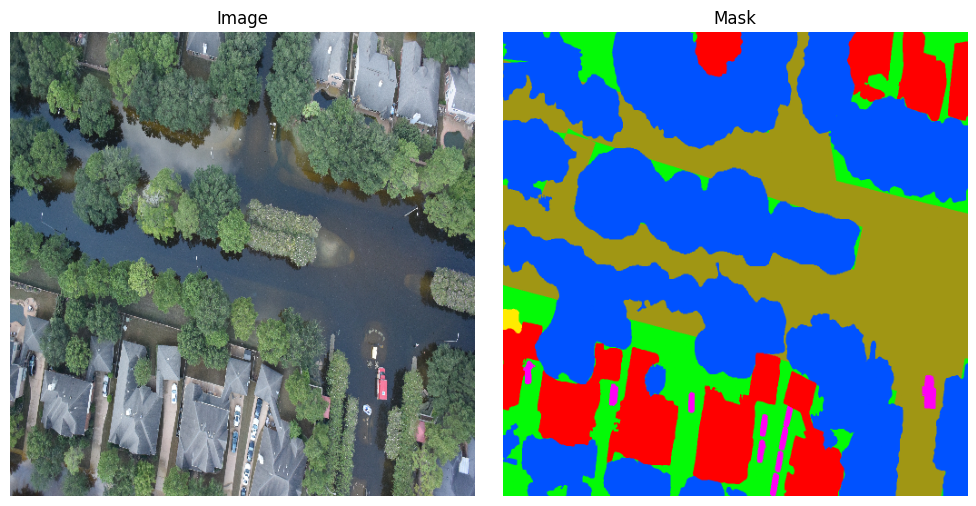

In [32]:
# Sample image

def load_image(path):
    """
    Loads an image or mask, same preprocessing used later for training but higher res
    """
    image = cv2.imread(path)
    image = cv2.resize(image, (512,512))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    return image

fig, ax = plt.subplots(1,2, figsize=(10,5))

i = np.random.randint(0, len(train_pathS_m))

ax[0].imshow(load_image(train_pathS[i]))
ax[0].set_title('Image')
ax[1].imshow(load_image(train_pathS_m[i]))
ax[1].set_title('Mask')
ax[0].axis('off')
ax[1].axis('off')
plt.tight_layout()

plt.show()

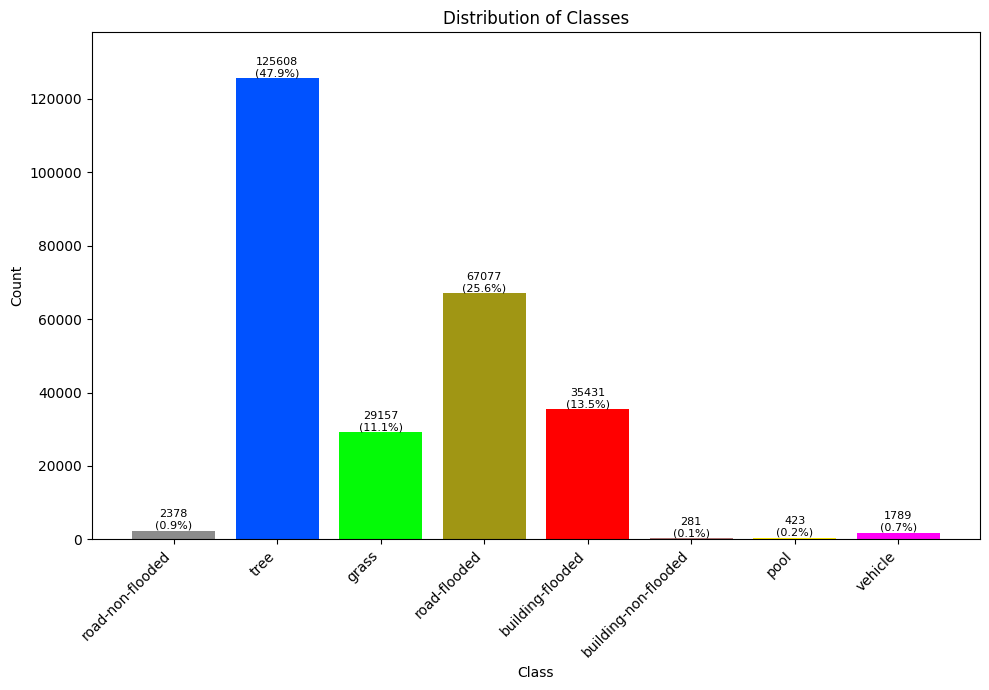

In [38]:
# Class frequency in segmented image

def find_closest_color(pixel, palette):
    '''
    Matches each pixel to the closest in the normalized palette,
    usefull because we can encounter variations caused by compression
    artifacts, rounding errors, or other preprocessing steps
    '''
    distances = np.linalg.norm(palette - pixel, axis=1)
    return tuple(palette[np.argmin(distances)])


def class_counter(mask, palette, classes_palette):
    """
    Counts the occurrences of each class in the mask image.
    """
    pixels = [find_closest_color(pixel, palette) for row in mask for pixel in row]
    pixel_counts = Counter(pixels)

    df = pd.DataFrame(list(pixel_counts.items()), columns=['RGB_norm', 'Count'])
    df['Class'] = df['RGB_norm'].map(classes_palette)
    df['Percentage'] = (df['Count'] / df['Count'].sum()) * 100

    return df

def plot_class_distribution(df):
    """
    Plots the distribution of classes.
    """
    plt.figure(figsize=(10,7))
    bars = plt.bar(df['Class'], df['Count'], color=[tuple(rgb) for rgb in df['RGB_norm']])

    # Percentages on top of bars
    for bar, count in zip(bars, df['Count']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{count}\n({count / df["Count"].sum() * 100:.1f}%)',
                 ha='center', va='bottom', fontsize=8)

    plt.ylim(0, max(df['Count']) + max(df['Count']) * 0.10)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Classes')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

mask = load_image(train_pathS_m[i])
df = class_counter(mask, normalized_palette, classes_palette)
plot_class_distribution(df)


### Data Preparation

In [ ]:
# Dataset class creation

class FloodNetDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform = None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        '''
        Resizes images and masks to 256x256 for computational efficiency, converts
        BGR color map to RGB and normalizes into 0-1 range
        '''
        image = cv2.imread(self.image_paths[idx])
        image = cv2.resize(image, (256, 256))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.resize(mask, (256, 256))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        '''
        Encodes mask RGB values to integer labels 0-9, required for the chosen criterion
        '''
        mask_labels = np.zeros((256, 256), dtype=np.int64)
        for i, color in enumerate(RGBs):
                mask_labels[(mask == color).all(axis=-1)] = i

        if self.transform:
            augmented = self.transform(image=image, mask=mask_labels)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [ ]:
# Basic data augmentation (with albumentations)

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    ToTensorV2()
])

val_transforms = A.Compose([
    ToTensorV2()
])


In [ ]:
# Create the datasets and define DataLoaders

train_dataset = FloodNetDataset(train_pathS, train_pathS_m, transform=train_transforms)
val_dataset = FloodNetDataset(val_pathS, val_pathS_m, transform=val_transforms)
test_dataset = FloodNetDataset(test_pathS, test_pathS_m, transform=val_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train loader size: 181
Validation loader size: 57
Test loader size: 56


### Model Initialization

To **initialize the model**, I used the `segmentation_models_pytorch` library, a comprehensive library based on PyTorch designed for image segmentation tasks.
Specifically, i trained two different models:
- **Unet:** This is a fully convolutional neural network designed for image semantic segmentation. It consists of encoder and decoder parts connected with skip connections. The encoder extracts features of varying spatial resolutions, which the decoder uses to create precise segmentation masks.
- **FPN**: Feature Pyramid Network works by extracting features from images of various sizes. It starts by building a hierarchy of features at different scales from the bottom up. Then, it enhances these features by blending rough details from higher levels with finer details from lower levels. This approach helps the models capture detailed meaning and locate features accurately across different sizes in the image.

Both models utilize a ResNet34 backbone pretrained on the ImageNet dataset. Additionally, I applied the **Dice Loss** function from the same library to effectively measure the overlap between the predicted segmentation maps and the ground truth masks.

As an alternative approach, I could have retrieved models and their corresponding weights directly from the `PyTorch` library `torchvision.models` and `torchvision.models.segmentation.`

**_References:_**
- [Segmentation Models Repository](https://github.com/qubvel/segmentation_models.pytorch)
- [PyTorch models](https://pytorch.org/vision/stable/models.html)

In [ ]:
# Load pretrained model and define optimizer and loss function

model = smp.Unet(encoder_name="resnet34",
                 encoder_weights="imagenet",
                 classes=len(classes),
                 activation=None)

#model = smp.FPN(encoder_name='resnet34',
#              encoder_weights='imagenet',
#              in_channels=3,
#              classes=len(classes),
#              activation=None)

# This freezes the encoder part and allows training to work only on the decoder part (slightly faster)
#for param in model.encoder.parameters():
#    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, classes=len(classes))

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 52.5MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Training

In [ ]:
# Define training and validation procedures

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for images, masks in tqdm(loader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Compute predictions
        _, preds = torch.max(outputs, 1)

        # Calculate accuracy
        correct_pixels += (preds == masks).sum().item()
        total_pixels += torch.numel(masks)

    accuracy = correct_pixels / total_pixels
    return train_loss / len(loader), accuracy


def validate_epoch(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in tqdm(loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Compute predictions
            _, preds = torch.max(outputs, 1)

            # Calculate accuracy
            correct_pixels += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)

    accuracy = correct_pixels / total_pixels
    return val_loss / len(loader), accuracy


In [ ]:
# Training loop

num_epochs = 25
best_val_loss = float('inf')

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

print("Training completed.")

100%|██████████| 57/57 [01:36<00:00,  1.70s/it]


Epoch 1/25
Train Loss: 0.7326, Train Accuracy: 0.4467
Val Loss: 0.4944, Val Accuracy: 0.7784


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 2/25
Train Loss: 0.5847, Train Accuracy: 0.7047
Val Loss: 0.4314, Val Accuracy: 0.7733


100%|██████████| 57/57 [01:24<00:00,  1.48s/it]


Epoch 3/25
Train Loss: 0.5199, Train Accuracy: 0.7389
Val Loss: 0.4081, Val Accuracy: 0.7927


100%|██████████| 57/57 [01:23<00:00,  1.47s/it]


Epoch 4/25
Train Loss: 0.4874, Train Accuracy: 0.7640
Val Loss: 0.3604, Val Accuracy: 0.8143


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 5/25
Train Loss: 0.4352, Train Accuracy: 0.7661
Val Loss: 0.3373, Val Accuracy: 0.7931


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 6/25
Train Loss: 0.3997, Train Accuracy: 0.7752
Val Loss: 0.3157, Val Accuracy: 0.8202


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 7/25
Train Loss: 0.3889, Train Accuracy: 0.7771
Val Loss: 0.3149, Val Accuracy: 0.8038


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 8/25
Train Loss: 0.3786, Train Accuracy: 0.7881
Val Loss: 0.3032, Val Accuracy: 0.8250


100%|██████████| 57/57 [01:22<00:00,  1.45s/it]


Epoch 9/25
Train Loss: 0.3762, Train Accuracy: 0.7891
Val Loss: 0.3085, Val Accuracy: 0.8182


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 10/25
Train Loss: 0.3598, Train Accuracy: 0.7963
Val Loss: 0.2926, Val Accuracy: 0.8312


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 11/25
Train Loss: 0.3592, Train Accuracy: 0.7884
Val Loss: 0.3027, Val Accuracy: 0.8234


100%|██████████| 57/57 [01:23<00:00,  1.47s/it]


Epoch 12/25
Train Loss: 0.3596, Train Accuracy: 0.7988
Val Loss: 0.3033, Val Accuracy: 0.8145


100%|██████████| 57/57 [01:23<00:00,  1.47s/it]


Epoch 13/25
Train Loss: 0.3452, Train Accuracy: 0.8008
Val Loss: 0.2897, Val Accuracy: 0.8163


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 14/25
Train Loss: 0.3505, Train Accuracy: 0.8002
Val Loss: 0.2832, Val Accuracy: 0.8220


100%|██████████| 57/57 [01:26<00:00,  1.51s/it]


Epoch 15/25
Train Loss: 0.3451, Train Accuracy: 0.8070
Val Loss: 0.2840, Val Accuracy: 0.8253


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 16/25
Train Loss: 0.3398, Train Accuracy: 0.8072
Val Loss: 0.2795, Val Accuracy: 0.8276


100%|██████████| 57/57 [01:45<00:00,  1.85s/it]


Epoch 17/25
Train Loss: 0.3478, Train Accuracy: 0.8058
Val Loss: 0.2868, Val Accuracy: 0.8111


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 18/25
Train Loss: 0.3389, Train Accuracy: 0.8079
Val Loss: 0.2754, Val Accuracy: 0.8323


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 19/25
Train Loss: 0.3251, Train Accuracy: 0.8219
Val Loss: 0.2793, Val Accuracy: 0.8350


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 20/25
Train Loss: 0.3302, Train Accuracy: 0.8227
Val Loss: 0.2821, Val Accuracy: 0.8093


100%|██████████| 57/57 [01:23<00:00,  1.47s/it]


Epoch 21/25
Train Loss: 0.3201, Train Accuracy: 0.8149
Val Loss: 0.2752, Val Accuracy: 0.8304


100%|██████████| 57/57 [01:23<00:00,  1.47s/it]


Epoch 22/25
Train Loss: 0.3205, Train Accuracy: 0.8179
Val Loss: 0.2775, Val Accuracy: 0.8282


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 23/25
Train Loss: 0.3157, Train Accuracy: 0.8258
Val Loss: 0.2838, Val Accuracy: 0.8194


100%|██████████| 57/57 [01:23<00:00,  1.47s/it]


Epoch 24/25
Train Loss: 0.3125, Train Accuracy: 0.8246
Val Loss: 0.2762, Val Accuracy: 0.8343


100%|██████████| 57/57 [01:23<00:00,  1.46s/it]


Epoch 25/25
Train Loss: 0.3108, Train Accuracy: 0.8349
Val Loss: 0.2711, Val Accuracy: 0.8418
Training completed.


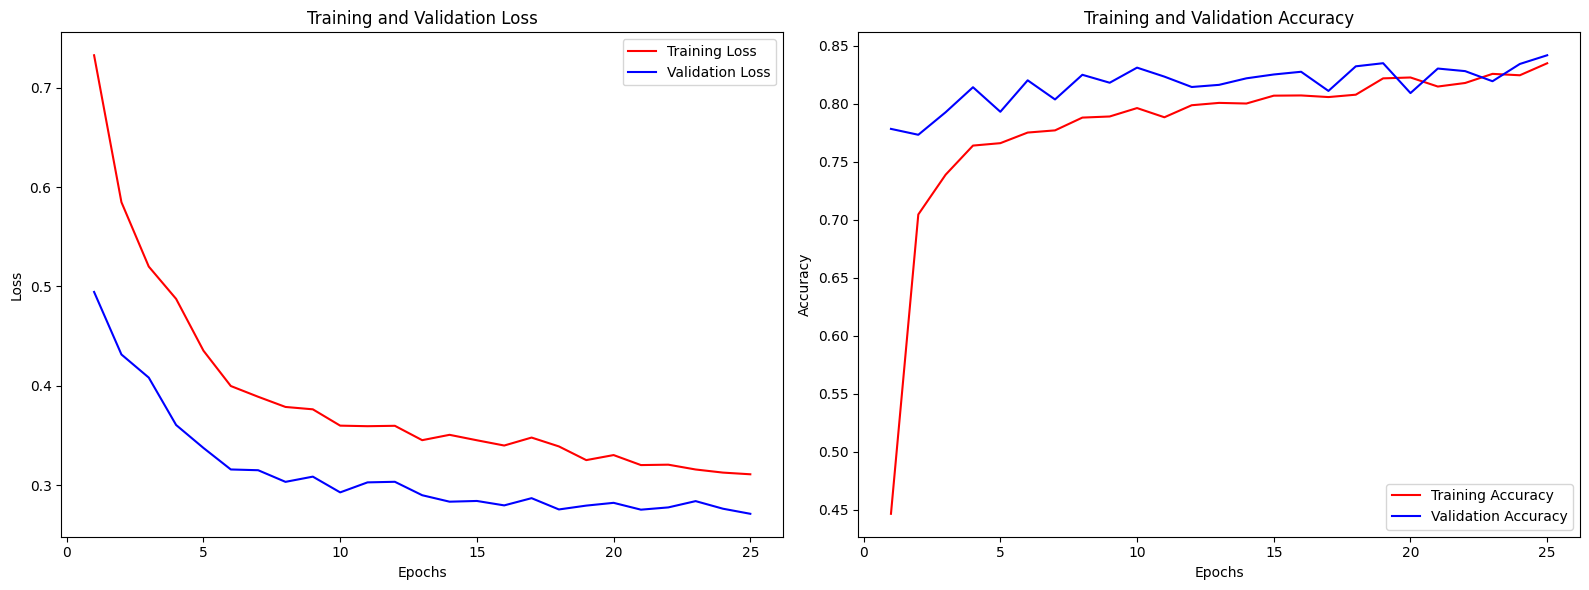

In [ ]:
# Training and validation metrics over epochs

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    train_losses_np = np.array(train_losses)
    val_losses_np = np.array(val_losses)
    train_accuracies_np = np.array(train_accuracies)
    val_accuracies_np = np.array(val_accuracies)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(epochs, train_losses_np, 'r-', label='Training Loss')
    ax1.plot(epochs, val_losses_np, 'b-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, train_accuracies_np, 'r-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies_np, 'b-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()


plot_metrics(train_losses, val_losses, train_accs, val_accs)

### Model Evaluation

In [ ]:
# Load the best model for inference
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Evaluate on the test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print("")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

100%|██████████| 56/56 [01:54<00:00,  2.05s/it]


Test Loss: 0.2736
Test Accuracy: 0.8368


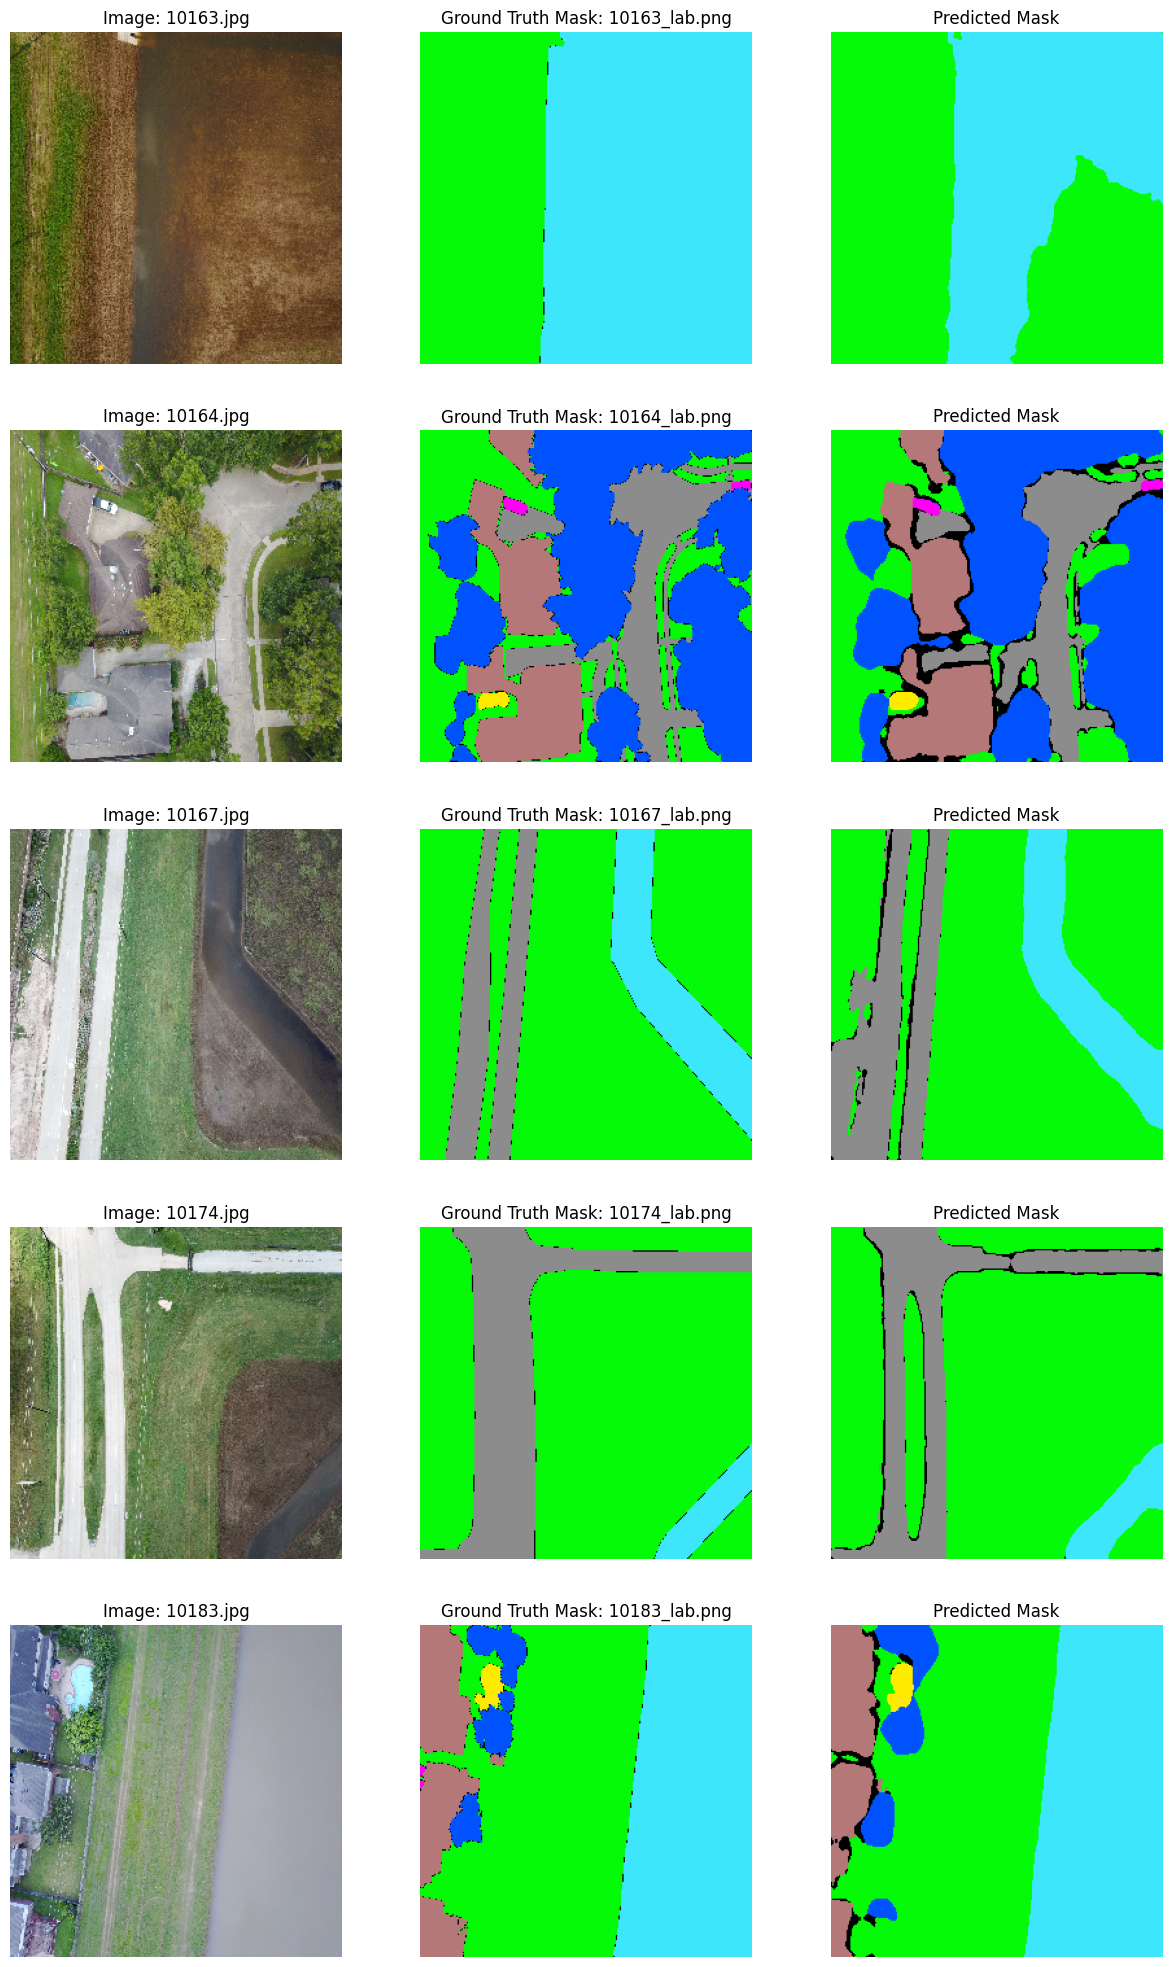

In [ ]:
# Visualization of 5 examples from the test set

def decode_segmap(mask, colors):
    seg_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        seg_img[mask == i] = color
    return seg_img

# Function to plot examples
def plot_examples(model, loader, device, colors, image_paths, mask_paths, num_examples=5):
    model.eval()
    images, masks, preds, filenames = [], [], [], []
    with torch.no_grad():
        for i, (image, mask) in enumerate(loader):
            if i >= num_examples:
                break
            image = image.to(device)
            pred = model(image).argmax(dim=1).cpu().numpy()
            images.append(image.cpu().numpy().transpose(0, 2, 3, 1))
            masks.append(mask.numpy())
            preds.append(pred)
            filenames.append((image_paths[i], mask_paths[i]))

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))
    for i in range(num_examples):
        img = images[i][0]
        mask = masks[i][0]
        pred = preds[i][0]
        decoded_mask = decode_segmap(mask, colors)
        decoded_pred = decode_segmap(pred, colors)

        img_filename = os.path.basename(filenames[i][0])
        mask_filename = os.path.basename(filenames[i][1])

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image: {img_filename}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(decoded_mask)
        axes[i, 1].set_title(f"Ground Truth Mask: {mask_filename}")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(decoded_pred)
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.show()


test_image_paths = test_dataset.image_paths
test_mask_paths = test_dataset.mask_paths
plot_examples(model, test_loader, device, RGBs, test_image_paths, test_mask_paths)

In [ ]:
# Intersection over Union

def compute_iou(mask1, mask2, num_classes=10):
    '''
   Computes the IoU for each class for a single mask-prediction pair
    '''
    ious = []
    for c in range(num_classes):
        intersection = ((mask1 == c) & (mask2 == c)).sum().item()
        union = ((mask1 == c) | (mask2 == c)).sum().item()
        iou = intersection / union if union != 0 else 0.0
        ious.append(iou)
    return ious

def IoU(model, loader, device, num_classes=10):
    '''
    Computes the IoU for each class for all mask-prediction pairs, then:
    - Computes the class-wise IoUs as the average IoU for each class across all pairs
    - Computes the overall mean IoU as the average of the class-wise IoUs
    '''
    model.eval()
    total_ious = []
    with torch.no_grad():
        for image, mask in loader:
            image = image.to(device)
            pred = model(image).argmax(dim=1).cpu().numpy()
            mask = mask.numpy()

            for m, p in zip(mask, pred):
                ious = compute_iou(m, p, num_classes)
                total_ious.append(ious)

    total_ious = np.array(total_ious)
    mean_ious_per_class = np.mean(total_ious, axis=0)
    overall_mean_iou = np.mean(mean_ious_per_class)

    return overall_mean_iou, mean_ious_per_class

mean_iou, iou_per_class = IoU(model, test_loader, device)

In [ ]:
def compute_dice(mask1, mask2, num_classes=10):
    '''
    Computes the Dice coefficient for each class for a single mask-prediction pair.
    '''
    dices = []
    for c in range(num_classes):
        intersection = ((mask1 == c) & (mask2 == c)).sum().item()
        size_mask1 = (mask1 == c).sum().item()
        size_mask2 = (mask2 == c).sum().item()
        dice = (2 * intersection) / (size_mask1 + size_mask2) if (size_mask1 + size_mask2) != 0 else 0.0
        dices.append(dice)
    return dices

def Dice(model, loader, device, num_classes=10):
    '''
    Computes the Dice coefficient for each class for all mask-prediction pairs, then:
    - Computes the class-wise Dice coefficients as the average Dice coefficient for each class across all pairs.
    - Computes the overall mean Dice coefficient as the average of the class-wise Dice coefficients.
    '''
    model.eval()
    total_dices = []
    with torch.no_grad():
        for image, mask in loader:
            image = image.to(device)
            pred = model(image).argmax(dim=1).cpu().numpy()
            mask = mask.numpy()

            for m, p in zip(mask, pred):
                dices = compute_dice(m, p, num_classes)
                total_dices.append(dices)

    total_dices = np.array(total_dices)
    mean_dices_per_class = np.mean(total_dices, axis=0)
    overall_mean_dice = np.mean(mean_dices_per_class)

    return overall_mean_dice, mean_dices_per_class


mean_dice, dice_per_class = Dice(model, test_loader, device)


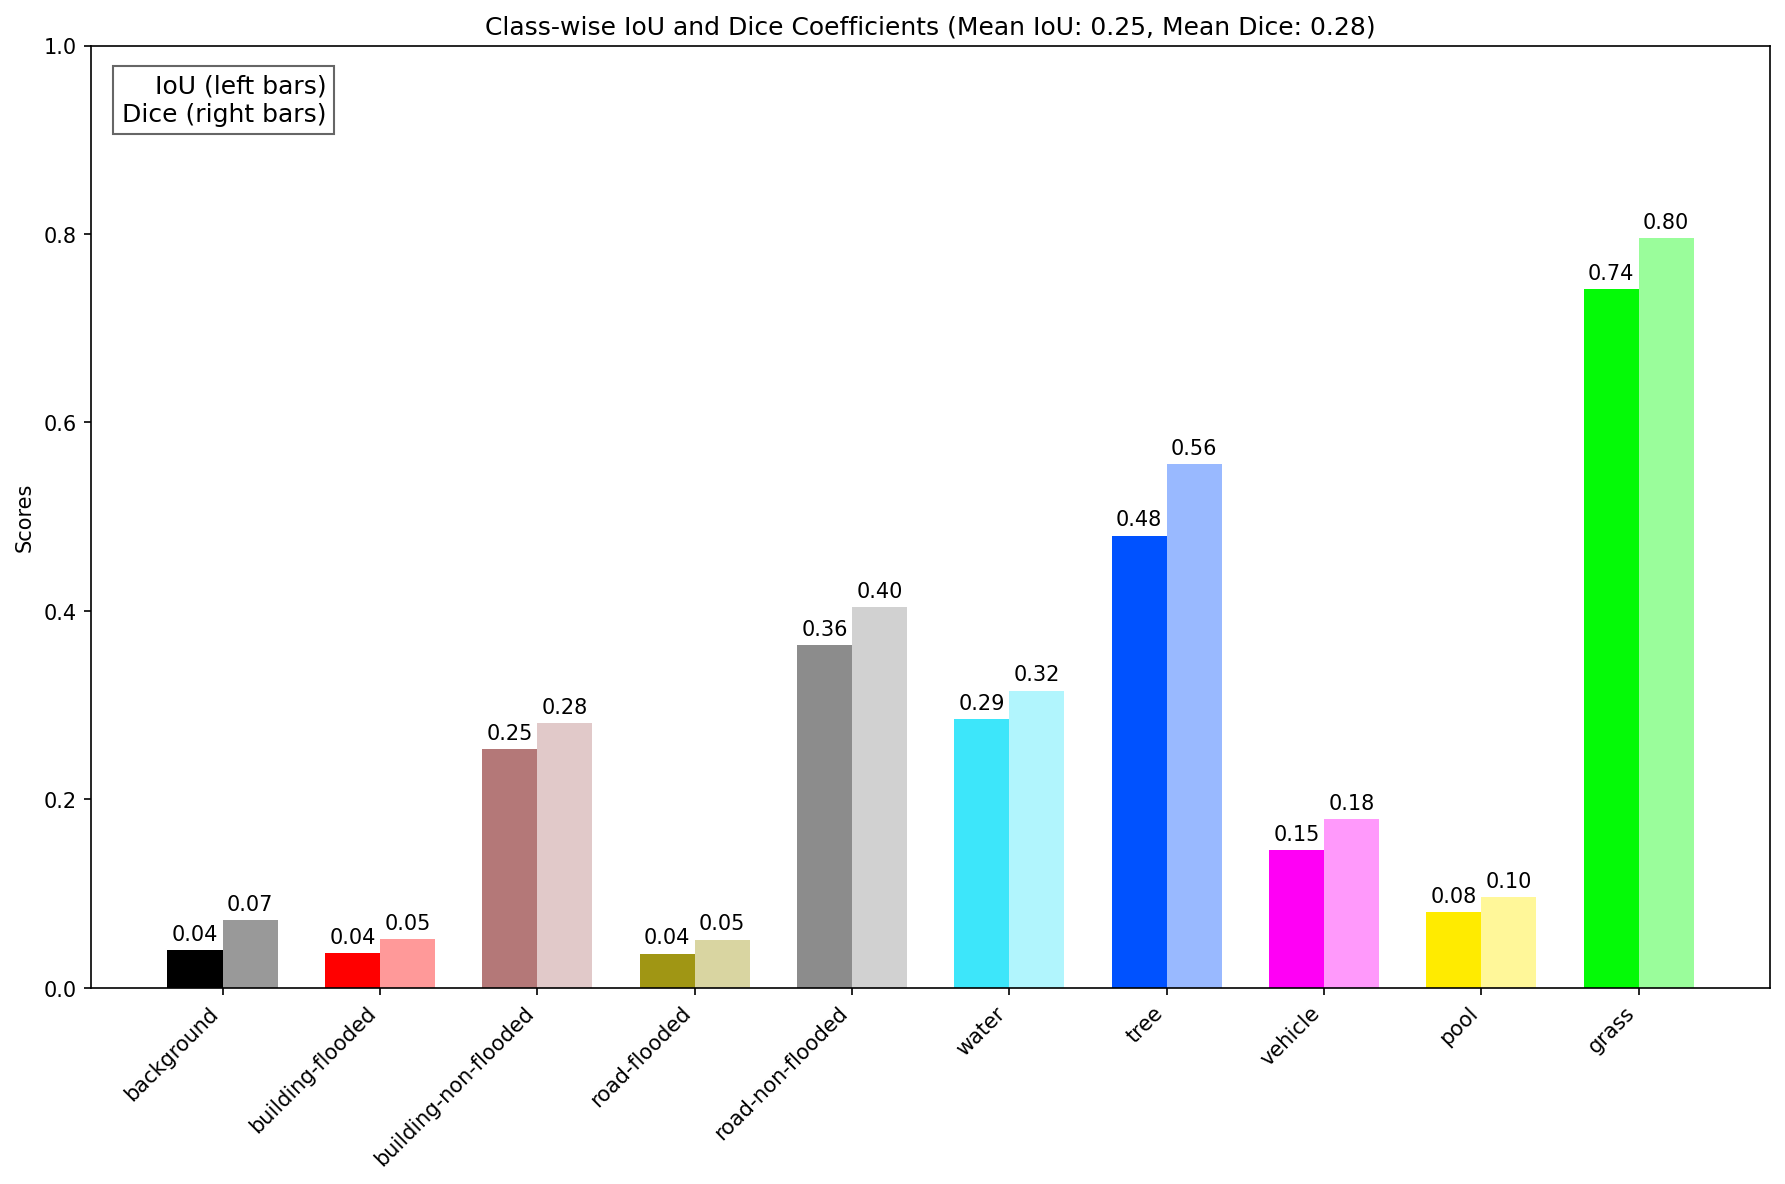

In [ ]:
def plot_metrics(iou_per_class, dice_per_class, overall_mean_iou, overall_mean_dice, classes, colors):
    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8), dpi=150)

    bars_iou = ax.bar(x - width/2, iou_per_class, width, label='IoU', color=colors)
    bars_dice = ax.bar(x + width/2, dice_per_class, width, label='Dice', color=colors, alpha = 0.4)

    ax.set_ylabel('Scores')
    ax.set_ylim(0, 1)
    ax.set_title(f'Class-wise IoU and Dice Coefficients (Mean IoU: {overall_mean_iou:.2f}, Mean Dice: {overall_mean_dice:.2f})')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45, ha='right')

    # Custom legend
    ax.text(0.14, 0.97, 'IoU (left bars)\nDice (right bars)', transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.6))


    # Attach a text label above each bar in rects, displaying its height.
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(bars_iou)
    autolabel(bars_dice)

    fig.tight_layout()
    plt.show()

# Plot the IoU and Dice scores
plot_metrics(iou_per_class, dice_per_class, mean_iou, mean_dice, classes, normalized_palette_tuples)